# Gaussian Process Classifier Example
### Using Expectation Propagation algorithm
### 1-Dimensional input space, 2-Class classification problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import norm, multivariate_normal

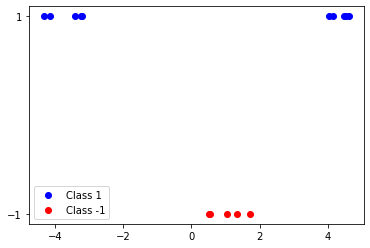

In [24]:
# Generate Data for One dimensional binary classification
n = 5 # sample per cluster

X1 = np.random.uniform(-5,-3, n)
X2 = np.random.uniform(0,2,n)
X3 = np.random.uniform(3,5,n)
y = np.concatenate((np.ones(n), -np.ones(n), np.ones(n)))
X = np.concatenate((X1, X2, X3))

# Plot the data
plt.scatter([X1,X3], [np.ones(n), np.ones(n)], c='b', label='Class 1')
plt.scatter(X2, -np.ones(n), c='r', label='Class -1')
plt.yticks([-1,1])
plt.legend()
plt.savefig('plots/GP_binary_data.png', facecolor='w', edgecolor='w', transparent=False, bbox_inches='tight')

In [110]:
# Define the kernel function
def kernel(x1, x2):
    return np.exp(-0.5*np.sum((x1-x2)**2))

# Define the covariance matrix
def cov_matrix(X, kernel):
    n = len(X)
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = kernel(X[i], X[j])
    return K

In [111]:
# covariance matrix
K = cov_matrix(X, kernel)
K.shape

(15, 15)

In [145]:
# Define Expectation Propagation
from copy import deepcopy

def EP(K, y, max_iter=100):
    # Initialize
    N = len(y)
    nu = np.zeros(N) # cavity parameters
    tau = np.zeros(N)
    mu = np.zeros(N) # posterior parameters
    Sigma = deepcopy(K)  

    for _ in range(max_iter):
        for i in range(N):
            # Approximate cavity dist parameters
            cavity_mean = 1/K[i,i] * mu[i] - nu[i]
            cavity_var_inv = 1/K[i,i] - tau[i]
            cavity_var = 1/cavity_var_inv

            # marginal moments
            z_i = y[i] * cavity_mean / np.sqrt(1 + cavity_var)
            marginal_mean = cavity_mean + ((y[i] * cavity_var * norm.pdf(z_i)) / (norm.cdf(z_i) * np.sqrt(1 + cavity_var)))
            marginal_var = cavity_var - ((cavity_var**2 * norm.pdf(z_i)) / (norm.cdf(z_i) * (1 + cavity_var))) * (z_i + norm.pdf(z_i)/norm.cdf(z_i))

            # Update Site Parameters
            delta_tau = (1 / marginal_var) - cavity_var_inv - tau[i]
            tau[i] += delta_tau
            nu[i] = marginal_mean / marginal_var - cavity_mean

            # Update Posterior Parameters
            s_i = Sigma[:,i]
            Sigma = Sigma - (1 / (1/delta_tau + Sigma[i,i])) * np.outer(s_i, s_i)
            mu = Sigma @ nu

        # Recompute approximate posterior
        S = np.diag(tau)
        S_sqrt = np.sqrt(S)
        L = np.linalg.cholesky(np.eye(N) + S_sqrt @ K @ S_sqrt)
        V = np.linalg.solve(L.T, S_sqrt @ K)
        Sigma = K - V.T @ V
        mu = Sigma @ nu

    
    return nu, tau # natural site parameters

def predict_EP(X, y, nu, tau, x_new, kernel):
    N = len(y)
    K = cov_matrix(X, kernel)
    S = np.diag(tau)
    S_sqrt = np.sqrt(S)
    L = np.linalg.cholesky(np.eye(N) + S_sqrt @ K @ S_sqrt)
    z = np.linalg.solve(S_sqrt @ L.T, np.linalg.solve(L, S_sqrt @ K @ nu))
    kernel_vec = np.array([kernel(x_new, X[i]) for i in range(N)])
    mean_new = np.inner(z- nu, kernel_vec)
    v = np.linalg.solve(L, S_sqrt @ kernel_vec)
    var_new = kernel(x_new, x_new) - np.inner(v,v)

    pi_new = norm.cdf(mean_new / np.sqrt(1 + var_new))

    return mean_new, var_new, pi_new            

In [146]:
# Run EP
nu, tau = EP(K, y)

<ipython-input-145-f25941ba9c2e>:31: RuntimeWarning: divide by zero encountered in double_scalars
  Sigma = Sigma - (1 / (1/delta_tau + Sigma[i,i])) * np.outer(s_i, s_i)


In [147]:
# Predictive Distribution : EP

X_new = np.linspace(-7, 7, 100)
pi_EP = np.zeros(len(X_new))
mean_EP = np.zeros(len(X_new))
var_EP = np.zeros(len(X_new))

for i in range(len(X_new)):
    mean_EP[i], var_EP[i], pi_EP[i] = predict_EP(X, y, nu, tau, X_new[i], kernel)

In [149]:
# Laplace Approximation

def loglik(y, f):
    return np.sum(np.log(1 + np.exp(-y*f)))

from scipy.integrate import quad

def laplace_approximation(y, X, x_new=None, max_iter=100, kernel=kernel):
    K = cov_matrix(X, kernel)
    N = len(y)
    f = np.zeros(N)
    for i in range(max_iter):
        pi = np.exp(f) / (1 + np.exp(f))
        W = np.diag(pi * (1 - pi))
        W_sqrt = np.sqrt(W)
        L = np.linalg.cholesky(np.eye(N) + W_sqrt.dot(K).dot(W_sqrt)) # Cholesky decomposition
        t = (y + np.ones(N)) / 2 - pi
        b = W.dot(f) + t
        a = b - W_sqrt.dot(np.linalg.solve(L.T, np.linalg.solve(L, W_sqrt.dot(K).dot(b))))
        f = K.dot(a)

    pi = np.exp(f) / (1 + np.exp(f))
    W = np.diag(pi * (1 - pi))
    W_sqrt = np.sqrt(W)
    L = np.linalg.cholesky(np.eye(N) + W_sqrt.dot(K).dot(W_sqrt))
    t = (y + np.ones(N)) / 2 - pi
    b = W.dot(f) + t
    a = b - W_sqrt.dot(np.linalg.solve(L.T, np.linalg.solve(L, W_sqrt.dot(K).dot(b))))

    # approximate marginal log likelihood
    def q(y, X):
        return -0.5 * a.T.dot(f) + loglik(y, f) - np.sum(np.log(np.diag(L)))

    if x_new is None:
        return f, q, pi
    
    else: 
        # predictive mean
        k_new = np.array([kernel(x_new, X[i]) for i in range(len(X))])
        f_new = k_new.dot(t)
        # predictive variance
        v = np.linalg.solve(L, W_sqrt.dot(k_new))
        v_new = np.array(kernel(x_new, x_new)) - v.dot(v)
        # predictive class probability
        def integrand(z):
            return norm.cdf(z) * multivariate_normal(mean = f_new, cov = v_new).pdf(z)
        pi_new = quad(integrand, -100, 100)[0]

        return f_new, v_new, pi_new

In [150]:
# Predictive Distribution : Laplace Approximation
pi_laplace = np.zeros(len(X_new))
mean_laplace = np.zeros(len(X_new))
var_laplace = np.zeros(len(X_new))

for i in range(len(X_new)):
    mean_laplace[i], var_laplace[i], pi_laplace[i] = laplace_approximation(y, X, X_new[i], max_iter=100, kernel=kernel)

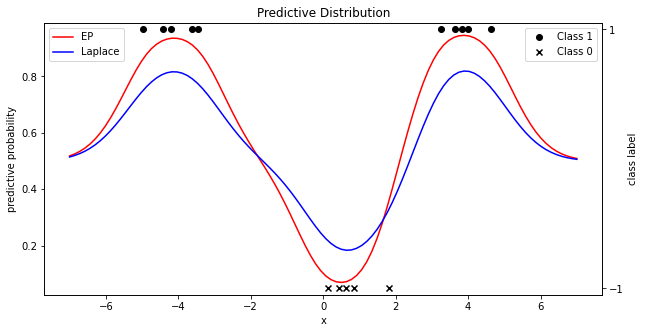

In [151]:
# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(X_new, pi_EP, color='red', label='EP')
ax1.plot(X_new, pi_laplace, color='blue', label='Laplace')
ax1.set_xlabel('x')
ax1.set_ylabel('predictive probability')

ax2.scatter([X1,X3], [np.ones(n), np.ones(n)], c='k', label='Class 1', marker='o')
ax2.scatter(X2, -np.ones(n), c='k', label='Class 0', marker='x')
ax2.set_ylabel('class label')
ax2.set_ylim(-1.05, 1.05)
ax2.set_yticks([-1, 1])

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Predictive Distribution')
plt.savefig('plots/Predictive_EP_Laplace.png', facecolor='white', bbox_inches='tight')

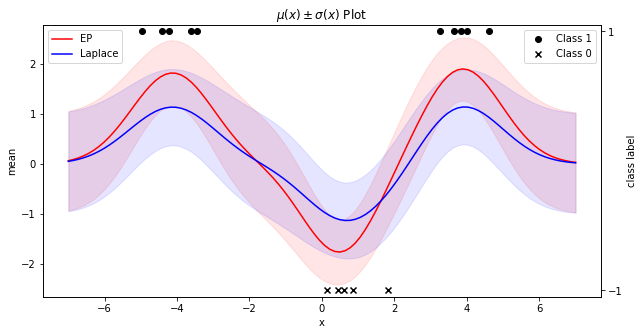

In [155]:
# Mean-STD Plot

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(X_new, mean_EP, color='red', label='EP')
ax1.plot(X_new, mean_laplace, color='blue', label='Laplace')
ax1.fill_between(X_new, mean_EP - np.sqrt(var_EP), mean_EP + np.sqrt(var_EP), color='red', alpha=0.1)
ax1.fill_between(X_new, mean_laplace - np.sqrt(var_laplace), mean_laplace + np.sqrt(var_laplace), color='blue', alpha=0.1)
ax1.set_xlabel('x')
ax1.set_ylabel('mean')

ax2.scatter([X1,X3], [np.ones(n), np.ones(n)], c='k', label='Class 1', marker='o')
ax2.scatter(X2, -np.ones(n), c='k', label='Class 0', marker='x')
ax2.set_ylabel('class label')
ax2.set_ylim(-1.05, 1.05)
ax2.set_yticks([-1, 1])

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('$\mu(x)\pm \sigma(x)$ Plot')
plt.savefig('plots/Mean_STD_EP_Laplace.png', facecolor='white', bbox_inches='tight')

# With `GPy` library

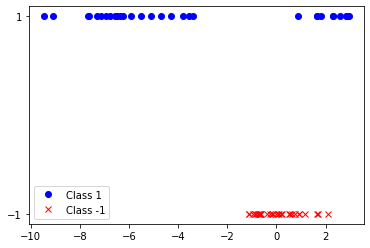

In [21]:
# Generate Data for One dimensional binary classification
np.random.seed(1)

X1 = np.random.normal(-6, 1.5, 20)
X2 = np.random.normal(0,1, 30)
X3 = np.random.normal(2,1, 10)
y = np.concatenate((np.ones(len(X1)), -np.ones(len(X2)), np.ones(len(X3))))
X = np.concatenate((X1, X2, X3))

# Plot the data
plt.plot(np.concatenate((X1, X3)), np.ones(len(X1)+len(X3)), 'bo', label='Class 1')
plt.plot(X2, -np.ones(len(X2)), 'rx', label='Class -1')
plt.yticks([-1,1])
plt.legend()
plt.savefig('plots/GP_binary_data.png', facecolor='w', edgecolor='w', transparent=False, bbox_inches='tight')

In [29]:
import GPy

# Define the kernel function
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=0.3)

ep = GPy.inference.latent_function_inference.expectation_propagation.EP()
la = GPy.inference.latent_function_inference.Laplace()

gpc_ep = GPy.models.GPClassification(X[:,None], y[:,None], kernel=kernel, inference_method=ep)
gpc_la = GPy.models.GPClassification(X[:,None], y[:,None], kernel=kernel, inference_method=la)

for i in range(5):
    gpc_ep.optimize('bfgs', max_iters=100)

nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize


 /Users/dangchan/miniforge3/envs/torch/lib/python3.8/site-packages/GPy/likelihoods/bernoulli.py:123: RuntimeWarning:invalid value encountered in sqrt


{'dataplot': [<matplotlib.collections.PathCollection at 0x15aa6d3d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x15aa6da30>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x15aa6db80>]}

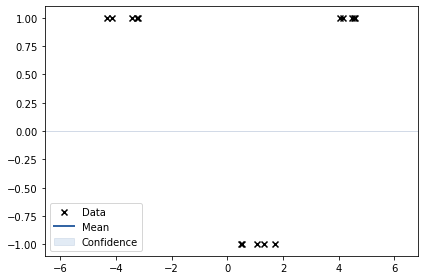

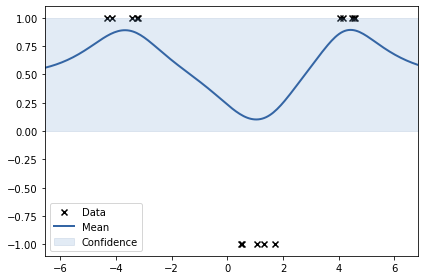

In [27]:
gpc_ep.plot()
gpc_la.plot()